# Φάση 1: Σύστημα Ανάκτησης Πληροφορίας

### Στόχος και Αντικείμενο
Στο πλαίσιο της παρούσας προγραμματιστικής εργασίας, ζητείται η ανάπτυξη, βελτιστοποίηση και αξιολόγηση ενός συστήματος Ανάκτησης Πληροφορίας (IR) με χρήση της μηχανής **Elasticsearch**. Το αντικείμενο μελέτης περιλαμβάνει μια συλλογή εγγράφων ερευνητικών έργων και ένα σύνολο ερωτημάτων φυσικής γλώσσας.

Κύριος στόχος είναι η επίτευξη υψηλής **ακρίβειας (Precision)** στα πρώτα αποτελέσματα και υψηλής **ανάκλησης (Recall)** στο σύνολο. Η αξιολόγηση της απόδοσης πραγματοποιείται βάσει των μετρικών **MAP**, **Precision@k** και **Recall@k**, όπως ορίζονται στις προδιαγραφές.

### Τεχνολογικό Υπόβαθρο
Τεχνολογικά, η υλοποίηση βασίζεται στον αλγόριθμο **BM25**, ένα πιθανοτικό μοντέλο κατάταξης που αποτελεί το standard στη βιομηχανία για αναζήτηση κειμένου. Το σύστημα ενισχύθηκε με τεχνικές Επεξεργασίας Φυσικής Γλώσσας (NLP), όπως **stemming** (αποκοπή καταλήξεων), **lemmatization** (λήμματα) και διαχείριση **συνωνύμων**, με σκοπό τη βελτιστοποίηση της **λεξιλογικής ταύτισης (Lexical Matching)**.

### Μεθοδολογική Προσέγγιση: Στρατηγική Πλεονασμού
Λαμβάνοντας υπόψη τον περιορισμένο όγκο της συλλογής δεδομένων, υιοθετήθηκε μια στρατηγική **σκόπιμου πλεονασμού** κατά τον σχεδιασμό του ευρετηρίου. Συγκεκριμένα, η πληροφορία κάθε εγγράφου αποθηκεύεται σε πολλαπλά πεδία με διαφορετικές μορφές (Raw Text, Stems, Lemmas, Synonyms).

Η επιλογή αυτή έγινε συνειδητά για δύο λόγους:
1.  **Αντιστάθμιση Σπανιότητας Δεδομένων (Data Sparsity):** Μειώνεται ο κίνδυνος επιστροφής μηδενικών αποτελεσμάτων σε αυστηρές αναζητήσεις (π.χ. λόγω διαφορετικής γραμματικής κλίσης), εξασφαλίζοντας υψηλότερη Ανάκληση.
2.  **Ευελιξία Πειραματισμού:** Επιτρέπει τον συνδυασμό διαφορετικών βαρών (boosting) ανά πεδίο, ώστε να βρεθεί η χρυσή τομή μεταξύ της αυστηρής ταύτισης και της ευρείας αναζήτησης.

### Πειραματική Διαδικασία και Αξιολόγηση
Η τελική αρχιτεκτονική διαμορφώθηκε κατόπιν πειραματισμού (**Ablation Study**), όπου αξιολογήθηκαν διάφορες στρατηγικές ευρετηρίασης. Συγκεκριμένα, εξετάστηκαν οι εξής παράμετροι:

* **N-grams (Bigrams):** Υλοποιήθηκε η ευρετηρίαση διγραμμάτων (token bigrams) για τον εντοπισμό εννοιών δύο λέξεων. Ωστόσο, η συγκριτική ανάλυση έδειξε ότι η **Φραστική Αναζήτηση (Phrase Matching)** κάλυπτε αποδοτικότερα την ανάγκη εντοπισμού διαδοχικών λέξεων, προσφέροντας υψηλότερη ακρίβεια χωρίς τον θόρυβο που εισήγαγαν τα bigrams. Ως εκ τούτου, η βαρύτητα των bigrams στο τελικό query μειώθηκε/μηδενίστηκε.
* **Διαχωρισμός Τίτλων (Title Extraction):** Δοκιμάστηκε η απόσπαση των τίτλων από το κυρίως κείμενο μέσω ευρετικών κανόνων. Η τεχνική αυτή δεν επέφερε βελτίωση στα αποτελέσματα, πιθανώς λόγω της ανομοιογένειας στη δομή των εγγράφων, και ως εκ τούτου δεν συμμετέχει ενεργά στην τελική εξίσωση κατάταξης.

Το τελικό μοντέλο εστιάζει στον βέλτιστο συνδυασμό **Phrase Matching** (για υψηλό Precision) και **Synonym/Stem Matching** (για υψηλό Recall).

In [22]:
%pip install pandas elasticsearch nltk matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### Εισαγωγή Βιβλιοθηκών και Αρχικοποίηση
Στο ακόλουθο κελί εισάγονται οι απαραίτητες βιβλιοθήκες Python (pandas, elasticsearch, nltk, sklearn). Επιπλέον, ορίζονται οι διαδρομές των αρχείων δεδομένων (έγγραφα, ερωτήματα, σχετικότητες) και του εκτελέσιμου αρχείου αξιολόγησης (trec_eval), καθώς και η σύνδεση με τον εξυπηρετητή Elasticsearch.

In [23]:
import pandas as pd
import numpy as np
from elasticsearch import Elasticsearch
from elasticsearch.helpers import bulk
import re
import html
import unicodedata
import subprocess
import os
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import matplotlib.pyplot as plt
try:
    from sklearn.metrics import precision_recall_curve, auc
except ImportError:
    pass

try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/wordnet')
    nltk.data.find('corpora/omw-1.4')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('omw-1.4')

es = Elasticsearch("http://localhost:9200")

file_docs = '../data/documents.csv'
file_queries = '../data/queries.csv'
qrels_file = "../data/qrels.txt"
trec_eval_path = "../../trec_eval/trec_eval.exe"

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anthi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anthi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anthi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\anthi\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Προεπεξεργασία Κειμένου και Γλωσσική Ανάλυση

Για τη βελτιστοποίηση του ευρετηρίου, προηγήθηκε στατιστική ανάλυση του κειμενικού σώματος (corpus analysis) μέσω βοηθητικών Python scripts. Η ανάλυση αυτή ανέδειξε συγκεκριμένα μοτίβα "θορύβου":

1.  **Λίστα `safe_noise`:** Εντοπίστηκαν λέξεις υψηλής συχνότητας (high-frequency terms) που είναι ειδικές για το συγκεκριμένο πεδίο (domain-specific stopwords), όπως "project", "aim", "proposal". Η αφαίρεσή τους κρίθηκε απαραίτητη καθώς εμφανίζονται σχεδόν σε όλα τα έγγραφα, μειώνοντας τη διακριτική ικανότητα του αλγορίθμου BM25.
2.  **Λίστα `boilerplate_phrases`:** Εντοπίστηκαν επαναλαμβανόμενες τυποποιημένες εκφράσεις (π.χ. "this project aims to", "work package"), οι οποίες δεν φέρουν σημασιολογική πληροφορία για το περιεχόμενο της έρευνας αλλά αποτελούν μέρος της διοικητικής δομής των κειμένων.

Η συνάρτηση προεπεξεργασίας αφαιρεί αυτά τα στοιχεία, εκτελεί tokenization και παράγει πολλαπλές μορφές των όρων (λήμματα, ρίζες και διγράμματα) για την ενίσχυση της αναζήτησης.

3.  **Μηχανισμός Εξαγωγής Τίτλων (Title Extraction):**
    Καθώς τα δεδομένα δεν διαθέτουν διακριτό πεδίο τίτλου, αναπτύχθηκε ένας ευρετικός αλγόριθμος (heuristic) εντοπισμού τίτλων. Παρατηρήθηκε ότι πολλά έγγραφα ακολουθούν τη δομή *"Τίτλος Έργου: Περιγραφή..."*. Ο αλγόριθμος εντοπίζει την πρώτη εμφάνιση της άνω-κάτω τελείας (`:`) και, εφόσον το τμήμα που προηγείται έχει λογικό μήκος (3-30 λέξεις), το εξάγει ως **Τίτλο**. Αυτό το πεδίο αποθηκεύεται ξεχωριστά (`title_extracted`) για να ενισχύσει τη σχετικότητα σε ερωτήματα που αναζητούν συγκεκριμένα ονόματα έργων.


Ορίζεται η διαδικασία προεπεξεργασίας (preprocessing pipeline) που εφαρμόζεται τόσο στα έγγραφα όσο και στα ερωτήματα. Η διαδικασία περιλαμβάνει:
* **Καθαρισμό:** Αφαίρεση ειδικών χαρακτήρων, σημείων στίξης και τυποποιημένων φράσεων (boilerplate phrases) που δεν προσφέρουν πληροφοριακή αξία.
* **Tokenization:** Διαχωρισμός του κειμένου σε λέξεις.
* **Αφαίρεση Stopwords:** Χρήση της λίστας του NLTK εμπλουτισμένης με ειδικές λέξεις θορύβου για το συγκεκριμένο πεδίο γνώσης.
* **Λημματοποίηση (Lemmatization) και Θεματική Ανάλυση (Stemming):** Αναγωγή των λέξεων στις ρίζες τους για τη βελτίωση της ανάκλησης.
* **Παραγωγή Διγραμμάτων (Bigrams):** Δημιουργία ζευγών λέξεων για την ενίσχυση του σημασιολογικού πλαισίου.
* **Εξαγωγή Τίτλου:** Υλοποίηση μηχανισμού εντοπισμού τίτλου βάσει στίξης (χρησιμοποιείται πειραματικά).

In [24]:
nltk_stops = set(stopwords.words('english'))
safe_noise = {
    "project", "aim", "proposal", "consortium", "summary", 
    "objective", "work", "package", "action", "activities",
    "main", "specific", "within", "during", "result", "presented",
    "paper", "study", "report", "deliverable", "task", "partners",
    "the", "and", "of", "in", "to", "a", "is", "for", "on", "that"
}
full_stopwords_list = list(nltk_stops.union(safe_noise))

boilerplate_phrases = [
    "the main objective of this project", "the aim of this project",
    "this project aims to", "this proposal aims to", "the goal of this proposal",
    "in this project", "in this proposal", "the proposed research",
    "will be carried out", "state of the art", "the overall objective",
    "establishing services enhancing the", "enhancing the innovation management",
    "development of a new", "development of a novel", "development of an innovative",
    "feasibility study of a", "understanding the role of", "elucidating the role of",
    "research and innovation","european union", "horizon 2020", "h2020", "fp7", 
    "grant agreement", "to achieve this goal", "proof of concept", "feasibility study"
]

def analyze_and_clean_safe(text):
    if not isinstance(text, str): return ""
    text = re.sub(r'\\[nrtfv]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = html.unescape(text)
    text = unicodedata.normalize('NFKC', text)
    text_lower = text.lower()
    for phrase in boilerplate_phrases:
        if phrase in text_lower:
            text = re.sub(re.escape(phrase), " ", text, flags=re.IGNORECASE)
    text = re.sub(r'[^a-zA-Z0-9\s:]', ' ', text) 
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def extract_title(text):
    if not isinstance(text, str): return ""
    if ':' in text:
        parts = text.split(':', 1)
        potential_title = parts[0].strip()
        if 3 <= len(potential_title.split()) <= 30:
            return potential_title
    return ""

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def apply_nlp(clean_text):
    if not clean_text: return {'lemma': '', 'stem': '', 'bigrams': ''}
    
    text_no_punct = clean_text.replace(':', ' ')
    tokens = word_tokenize(text_no_punct)
    
    filtered = [w for w in tokens if w not in full_stopwords_list and len(w) > 1]
    
    lemmas = [lemmatizer.lemmatize(w) for w in filtered]
    stems = [stemmer.stem(w) for w in filtered]
    
    bi_grams = list(ngrams(filtered, 2))
    bigrams_list = ["_".join(bg) for bg in bi_grams]
    
    return {
        'lemma': " ".join(lemmas),
        'stem': " ".join(stems),
        'bigrams': " ".join(bigrams_list)
    }

### Φόρτωση και Επεξεργασία Δεδομένων
Πραγματοποιείται η ανάγνωση των αρχείων εγγράφων (`documents.csv`) και ερωτημάτων (`queries.csv`). Στη συνέχεια, εφαρμόζονται οι συναρτήσεις προεπεξεργασίας σε κάθε εγγραφή. Για κάθε κείμενο δημιουργούνται πολλαπλές αναπαραστάσεις (καθαρό κείμενο, λήμματα, θέματα, διγράμματα), οι οποίες θα χρησιμοποιηθούν ως ξεχωριστά πεδία στο ευρετήριο για την υποστήριξη της υβριδικής αναζήτησης.

In [25]:
# Load & Process Data
df_docs = pd.read_csv(file_docs, header=None, names=['ID', 'Text'], dtype=str)
df_docs = df_docs[df_docs['ID'].str.lower() != 'id'].dropna(subset=['Text'])

df_docs['temp_text'] = df_docs['Text'].apply(analyze_and_clean_safe)
df_docs['extracted_title'] = df_docs['temp_text'].apply(extract_title)

nlp_docs = df_docs['temp_text'].apply(apply_nlp)

df_docs['clean_text'] = df_docs['temp_text'].apply(lambda x: x.replace(':', ' '))
df_docs['lemmatized_text'] = nlp_docs.apply(lambda x: x['lemma'])
df_docs['stemmed_text'] = nlp_docs.apply(lambda x: x['stem'])
df_docs['bigrams_text'] = nlp_docs.apply(lambda x: x['bigrams'])

# Load & Process Queries
df_queries = pd.read_csv(file_queries, header=None, names=['ID', 'Text'], dtype=str)
df_queries = df_queries[df_queries['ID'].str.lower() != 'id'].dropna(subset=['Text'])

df_queries['temp_text'] = df_queries['Text'].apply(analyze_and_clean_safe)
nlp_queries = df_queries['temp_text'].apply(apply_nlp)

df_queries['clean_text'] = df_queries['temp_text'].apply(lambda x: x.replace(':', ' '))
df_queries['lemmatized_text'] = nlp_queries.apply(lambda x: x['lemma'])
df_queries['stemmed_text'] = nlp_queries.apply(lambda x: x['stem'])
df_queries['bigrams_text'] = nlp_queries.apply(lambda x: x['bigrams'])

### 3. Παραμετροποίηση Ευρετηρίου Elasticsearch

Στο στάδιο αυτό καθορίζεται η αρχιτεκτονική του ευρετηρίου (Index Configuration), η οποία αποτελεί τον πυρήνα του συστήματος ανάκτησης. Η παραμετροποίηση εστιάζει στη διαχείριση της σημασιολογικής συσχέτισης μέσω συνωνύμων, στη βελτιστοποίηση του αλγορίθμου κατάταξης και στον ορισμό εξειδικευμένων αναλυτών.

#### Διαχείριση Συνωνύμων (Synonym Expansion)
Για την αντιμετώπιση του προβλήματος της αναντιστοιχίας λεξιλογίου (vocabulary mismatch), όπου το ερώτημα του χρήστη διαφέρει μορφολογικά από τους όρους του εγγράφου, ορίστηκε το φίλτρο `my_synonyms`.
Αυτή η τεχνική αυξάνει την Ανάκληση (Recall), καθώς επιτρέπει την ανάκτηση εγγράφων που αναφέρονται στην ίδια έννοια με διαφορετική ορολογία.

#### Ορισμός Αναλυτών
Δημιουργήθηκαν τρεις διακριτοί αναλυτές για να εξυπηρετήσουν διαφορετικές ανάγκες αναζήτησης:
1.  **`synonym_analyzer`:** Ενσωματώνει τα συνώνυμα, αφαίρεση stopwords και stemming. Χρησιμοποιείται στο βασικό πεδίο κειμένου για μέγιστη ανάκληση.
2.  **`exact_analyzer`:** Εφαρμόζει stemming και αφαίρεση stopwords, αλλά **όχι** συνώνυμα. Χρησιμοποιείται για να προσδώσει υψηλότερη βαρύτητα (Precision) σε έγγραφα που περιέχουν τους ακριβείς όρους του ερωτήματος.
3.  **`python_analyzer`:** Ένας απλός whitespace tokenizer που μετατρέπει σε πεζά γράμματα. Χρησιμοποιείται για τα πεδία που έχουν ήδη υποστεί επεξεργασία από την Python (λήμματα, ρίζες, διγράμματα).

#### Ρύθμιση Αλγορίθμου BM25
Εκτελέστηκε ειδικός αλγόριθμος βελτιστοποίησης για τον εντοπισμό των ιδανικών παραμέτρων:
* **`k1 = 2.0`:** Αυξάνει τον κορεσμό της συχνότητας όρων (Term Frequency saturation), δίνοντας μεγαλύτερη έμφαση στην επανάληψη λέξεων εντός του κειμένου.
* **`b = 1.0`:** Επιβάλλει πλήρη κανονικοποίηση βάσει μήκους (Full Length Normalization), ώστε να μην ευνοούνται τα μακροσκελή έγγραφα έναντι των συντομότερων.

#### Mappings
Κάθε έγγραφο ευρετηριάζεται σε πολλαπλά πεδία (`text`, `text.exact`, `text_lemmatized`, `text_stemmed`, `text_bigrams`, `title_extracted`), επιτρέποντας την εφαρμογή Υβριδικής Αναζήτησης όπου κάθε πεδίο συμμετέχει με διαφορετικό βάρος στο τελικό σκορ.

In [26]:
index_name = "ir_phase1_showcase"

settings = {
    "settings": {
        "number_of_shards": 1, "number_of_replicas": 0,
        "analysis": {
            "filter": {
                "my_custom_stop": { "type": "stop", "stopwords": full_stopwords_list },
                "my_length_filter": { "type": "length", "min": 2 },
                "my_synonyms": {
                    "type": "synonym",
                    "synonyms": [
                        "uk, united kingdom, great britain", "eu, european union, europe",
                        "us, usa, united states, america", "erc, european research council",
                        "h2020, horizon 2020", "fp7, framework programme 7",
                        "sme, smes, small medium enterprise, startup",
                        "res, renewable energy sources, renewables", "pv, photovoltaic, solar, solar energy",
                        "wind, wind energy, wind power, wind farm", "co2, carbon dioxide, greenhouse gas, ghg",
                        "climate, climate change, global warming", "ai, artificial intelligence, machine learning, ml, deep learning",
                        "ict, information communication technology, it", "iot, internet of things",
                        "big data, data analytics", "cloud, cloud computing", "5g, fifth generation",
                        "cancer, tumor, tumour, oncology", "hiv, aids", "dna, rna, genomics, genetic",
                        "pharma, pharmaceutical, drug, medicine", "agri, agriculture, agricultural, farming",
                        "food, agri food, agrifood"
                    ]
                },
                "my_stemmer": { "type": "stemmer", "language": "english" }
            },
            "analyzer": {
                "synonym_analyzer": {
                    "type": "custom", "tokenizer": "whitespace",
                    "filter": ["lowercase", "my_synonyms", "my_length_filter", "my_custom_stop", "my_stemmer"]
                },
                "exact_analyzer": {
                    "type": "custom", "tokenizer": "whitespace",
                    "filter": ["lowercase", "my_length_filter", "my_custom_stop", "my_stemmer"]
                },
                "python_analyzer": {
                    "type": "custom", "tokenizer": "whitespace",
                    "filter": ["lowercase"]
                }
            }
        },
        "index": { "similarity": { "default": { "type": "BM25", "b": 1.0, "k1": 2.0 } } }
    },
    "mappings": {
        "properties": {
            "text": { 
                "type": "text", "analyzer": "synonym_analyzer",
                "fields": { "exact": { "type": "text", "analyzer": "exact_analyzer" } }
            },
            "text_lemmatized": { "type": "text", "analyzer": "python_analyzer" },
            "text_stemmed": { "type": "text", "analyzer": "python_analyzer" },
            "text_bigrams": { "type": "text", "analyzer": "python_analyzer" },
            "title_extracted": { "type": "text", "analyzer": "synonym_analyzer", "similarity": "BM25" }
        }
    }
}

if es.indices.exists(index=index_name): es.indices.delete(index=index_name)
es.indices.create(index=index_name, body=settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'ir_phase1_showcase'})

### Ευρετηρίαση Εγγράφων
Εκτελείται η διαδικασία μαζικής εισαγωγής (bulk indexing) των επεξεργασμένων εγγράφων στο Elasticsearch. Το σύστημα αποθηκεύει τα έγγραφα μαζί με όλα τα μεταδεδομένα που παρήχθησαν κατά το στάδιο της προεπεξεργασίας.

In [27]:
bulk(es, ({
    "_index": index_name,
    "_source": { 
        "doc_id": row['ID'], 
        "text": row['clean_text'],
        "text_lemmatized": row['lemmatized_text'],
        "text_stemmed": row['stemmed_text'],
        "text_bigrams": row['bigrams_text'],
        "title_extracted": row['extracted_title']
    }
} for _, row in df_docs.iterrows()))
es.indices.refresh(index=index_name)

ObjectApiResponse({'_shards': {'total': 1, 'successful': 1, 'failed': 0}})

### Διαδικασία Αναζήτησης και Αξιολόγησης

Ο κώδικας εκτελεί τη διαδικασία ανάκτησης για τρία διαφορετικά σενάρια αποτελεσμάτων ($k \in \{20, 30, 50\}$). Η στρατηγική αναζήτησης βασίζεται σε ένα **Υβριδικό Ερώτημα (Hybrid Boolean Query)**, το οποίο συνδυάζει πολλαπλά πεδία με διαφορετικά βάρη (boosts).

#### Ανάλυση Στρατηγικής και Βαρών 
Η λογική απόδοσης βαρών σχεδιάστηκε ώστε να εξισορροπεί την Ανάκληση (Recall) με την Ακρίβεια (Precision):

* **Phrase Ranking (Boost 10.0 & 2.0):**
    * `match_phrase` με `slop: 0` (**Boost 10.0**): Αποτελεί τον ισχυρότερο παράγοντα κατάταξης. Αναζητά τις λέξεις του ερωτήματος **ακριβώς με τη σειρά** που δόθηκαν, χωρίς να παρεμβάλλονται άλλες λέξεις. Αν βρεθεί η ακριβής φράση, το έγγραφο θεωρείται εξαιρετικά σχετικό.
    * `match_phrase` με `slop: 2` (**Boost 2.0**): Επιτρέπει μικρή απόσταση (έως 2 λέξεις) μεταξύ των όρων, καλύπτοντας περιπτώσεις όπου παρεμβάλλεται ένα άρθρο ή επίθετο (π.χ. "solar *thermal* energy").

* **Precision - Exact Match (Boost 3.0):**
    * Το πεδίο `text.exact` αναζητά τους όρους όπως ακριβώς γράφτηκαν (χωρίς συνώνυμα). Του δίνεται υψηλή προτεραιότητα (3.0) γιατί η ύπαρξη της ακριβούς λέξης είναι πιο σημαντική από την ύπαρξη της ρίζας της.

* **Base Recall & Meaning (Boost 1.0 - 1.5):**
    * Τα πεδία `text`, `text_stemmed` (Boost 1.0) και `text_lemmatized` (Boost 1.5) λειτουργούν ως "δίχτυ ασφαλείας". Εξασφαλίζουν ότι θα ανακτηθούν έγγραφα ακόμα και αν οι λέξεις εμφανίζονται με διαφορετική κατάληξη ή μορφή, μεγιστοποιώντας την Ανάκληση.

#### Απενεργοποίηση Πεδίων 
Στον κώδικα παρατηρούνται δύο πεδία με μηδενικό βάρος (`boost: 0.0`). Αυτό αποτελεί συνειδητή επιλογή προκύπτουσα από πειραματική αξιολόγηση:

* **`text_bigrams` (Boost 0.0):** Παρόλο που τα διγράμματα (bigrams) εντοπίζουν έννοιες δύο λέξεων (π.χ. "climate_change"), τα πειράματα έδειξαν ότι η χρήση του ισχυρού `match_phrase` (Boost 10.0) κάλυπτε ήδη αυτή την ανάγκη αποδοτικότερα. Η ταυτόχρονη χρήση τους προκαλούσε θόρυβο στα αποτελέσματα, οπότε απενεργοποιήθηκαν για το τελικό μοντέλο.
* **`title_extracted` (Boost 0.0):** Η ευρετική μέθοδος εξαγωγής τίτλων αποδείχθηκε ασταθής λόγω της ανομοιογένειας στη δομή των εγγράφων. Η ενεργοποίησή της μείωνε ελαφρώς το MAP, επομένως αφαιρέθηκε από την τελική εξίσωση κατάταξης.

#### Σύγκριση Match Phrase vs. N-grams
Η επιλογή να δοθεί έμφαση στο `match_phrase` έναντι των `ngrams` (bigrams) βασίζεται στις θεμελιώδεις διαφορές τους:

* **Match Phrase:** Είναι δυναμικός έλεγχος. Το σύστημα ελέγχει τις **θέσεις (positions)** των λέξεων στο έγγραφο κατά την αναζήτηση. Εξασφαλίζει ότι η λέξη Α είναι δίπλα στη λέξη Β. Είναι πιο ακριβές για ερωτήματα φυσικής γλώσσας.
* **Bigrams (N-grams):** Είναι στατικός έλεγχος. Το ζεύγος "solar energy" αποθηκεύεται ως μία ενιαία "λέξη" (`solar_energy`) στο λεξιλόγιο. Αν και χρήσιμο για σταθερές ορολογίες, είναι λιγότερο ευέλικτο από το phrase matching και αυξάνει το μέγεθος του ευρετηρίου. Στη συγκεκριμένη υλοποίηση, το `match_phrase` αποδείχθηκε ανώτερο στην ανάκτηση σχετικών εγγράφων.

### Σχολιασμός Αποτελεσμάτων και Συμπεράσματα

Τα πειραματικά αποτελέσματα για $k=50$ επιδεικνύουν την υψηλή απόδοση του Υβριδικού Μοντέλου Αναζήτησης, επιτυγχάνοντας **(MAP) 0.8123**. Η ανάλυση των επιμέρους μετρικών οδηγεί στα εξής συμπεράσματα:

* **Εξαιρετική Ακρίβεια Κορυφής:**
    Η τιμή **Precision@5** αγγίζει το **0.9400**, γεγονός που υποδηλώνει ότι στα 5 πρώτα αποτελέσματα, σχεδόν και τα 5 είναι απολύτως σχετικά με το ερώτημα. Αυτό οφείλεται κυρίως στην υψηλή βαρύτητα (Boost 10.0) που δόθηκε στο `match_phrase`, το οποίο διασφαλίζει ότι οι χρήστες βρίσκουν άμεσα αυτό που ψάχνουν.

* **Σχεδόν Τέλεια Ανάκληση :**
    Η τιμή **Recall@50** φτάνει το **0.9900**. Αυτό σημαίνει ότι το σύστημα καταφέρνει να ανακτήσει το **99%** όλων των σχετικών εγγράφων που υπάρχουν στη συλλογή για τα δοσμένα ερωτήματα. Η επιτυχία αυτή πιστώνεται στη χρήση Συνωνύμων, Lemmatization και Stemming, τα οποία επέτρεψαν την ανάκτηση εγγράφων ακόμα και με διαφορετική ορολογία.

* **Σταθερότητα Κατάταξης:**
    Παρατηρούμε ότι καθώς αυξάνεται το $k$ (από 20 σε 50), το MAP βελτιώνεται σταθερά (από 0.74 σε 0.81), ενώ η Ακρίβεια (P@5) παραμένει σταθερή στο μέγιστο επίπεδο. Αυτό δείχνει ότι ο αλγόριθμος κατάταξης (BM25 με τα συγκεκριμένα boosts) είναι στιβαρός και τοποθετεί τα πιο σχετικά έγγραφα σταθερά στην κορυφή της λίστας.

Συνοψίζοντας, ο συνδυασμός της ακριβούς φραστικής αναζήτησης με τη σημασιολογική επέκταση (συνώνυμα/ρίζες) δημιούργησε ένα σύστημα που ισορροπεί βέλτιστα μεταξύ Ακρίβειας και Ανάκλησης.

In [28]:
k_scenarios = [20, 30, 50] 

for k in k_scenarios:
    output_file = f"../results/phase1_results_k{k}.txt"
    run_id = f"phase1_showcase_k{k}"
    os.makedirs(os.path.dirname(output_file) if os.path.dirname(output_file) else '.', exist_ok=True)
    
    with open(output_file, 'w') as f:
        for _, row in df_queries.iterrows():
            if not row['clean_text']: continue
            
            query_body = {
                "query": {
                    "bool": {
                        "should": [
                            # Base Recall
                            { "match": { "text": { "query": row['clean_text'], "boost": 1.0 } } },
                            { "match": { "text_stemmed": { "query": row['stemmed_text'], "boost": 1.0 } } },
                            
                            # Meaning
                            { "match": { "text_lemmatized": { "query": row['lemmatized_text'], "boost": 1.5 } } },
                            
                            # Context
                            { "match": { "text_bigrams": { "query": row['bigrams_text'], "boost": 0.0 } } },
                            
                            # Title Boost 
                            { "match": { "title_extracted": { "query": row['clean_text'], "boost": 0.0 } } },

                            # Precision
                            { "match": { "text.exact": { "query": row['clean_text'], "boost": 3.0 } } },
                            
                            # Phrase Ranking
                            { "match_phrase": { "text.exact": { "query": row['clean_text'], "slop": 0, "boost": 10.0 } } },
                            { "match_phrase": { "text.exact": { "query": row['clean_text'], "slop": 2, "boost": 2.0 } } }
                        ],
                        "minimum_should_match": 1
                    }
                },
                "size": k
            }
            res = es.search(index=index_name, body=query_body)
            
            for rank, hit in enumerate(res['hits']['hits']):
                f.write(f"{row['ID']}\tQ0\t{hit['_source']['doc_id']}\t{rank+1}\t{hit['_score']:.4f}\t{run_id}\n")

    print(f"Αποτελέσματα για k={k} αποθηκεύτηκαν.")
    
    try:
        cmd = [trec_eval_path, "-m", "map", "-m", "P.5,10,15,20", "-m", "recall.5,10,15,20,50", qrels_file, output_file]
        res = subprocess.run(cmd, capture_output=True, text=True)
        print(res.stdout)
    except Exception as e:
        pass


Αποτελέσματα για k=20 αποθηκεύτηκαν.
map                   	all	0.7478
P_5                   	all	0.9400
P_10                  	all	0.7900
P_15                  	all	0.7333
P_20                  	all	0.6600
recall_5              	all	0.3210
recall_10             	all	0.5265
recall_15             	all	0.7220
recall_20             	all	0.8658
recall_50             	all	0.8658

Αποτελέσματα για k=30 αποθηκεύτηκαν.
map                   	all	0.7941
P_5                   	all	0.9400
P_10                  	all	0.7900
P_15                  	all	0.7333
P_20                  	all	0.6600
recall_5              	all	0.3210
recall_10             	all	0.5265
recall_15             	all	0.7220
recall_20             	all	0.8658
recall_50             	all	0.9437

Αποτελέσματα για k=50 αποθηκεύτηκαν.
map                   	all	0.8123
P_5                   	all	0.9400
P_10                  	all	0.7900
P_15                  	all	0.7333
P_20                  	all	0.6600
recall_5              	all	0.3210
rec

### Καμπύλες Ακρίβειας-Ανάκλησης

Οι παραγόμενες καμπύλες επιβεβαιώνουν την υψηλή ποιότητα του συστήματος ανάκτησης, όπως αυτή αποτυπώθηκε και στις μετρικές MAP.

*  Όλες οι καμπύλες ξεκινούν από πολύ υψηλά επίπεδα στον άξονα Υ (Precision $\approx$ 0.94), γεγονός που καταδεικνύει ότι τα έγγραφα που κατατάσσονται στις κορυφαίες θέσεις είναι σχεδόν στο σύνολό τους σχετικά. Αυτό οφείλεται στην ισχυρή επίδραση της φραστικής αναζήτησης (Phrase Match).
* Παρατηρείται ότι η Ακρίβεια παραμένει υψηλή (>0.80) ακόμη και καθώς αυξάνεται η Ανάκληση (κίνηση προς τα δεξιά στον άξονα Χ). Αυτό σημαίνει ότι το σύστημα δεν εισάγει άμεσα μεγάλο όγκο "θορύβου" (μη σχετικών εγγράφων) καθώς προχωράμε χαμηλότερα στη λίστα αποτελεσμάτων.
*  Το εμβαδόν κάτω από την καμπύλη είναι υψηλό (άνω του 0.80), προσεγγίζοντας την πάνω δεξιά γωνία του διαγράμματος. Αυτό αποτελεί ένδειξη ενός εύρωστου συστήματος που επιτυγχάνει βέλτιστη ισορροπία μεταξύ της εύρεσης όλων των σχετικών εγγράφων και της αποφυγής λανθασμένων αποτελεσμάτων.

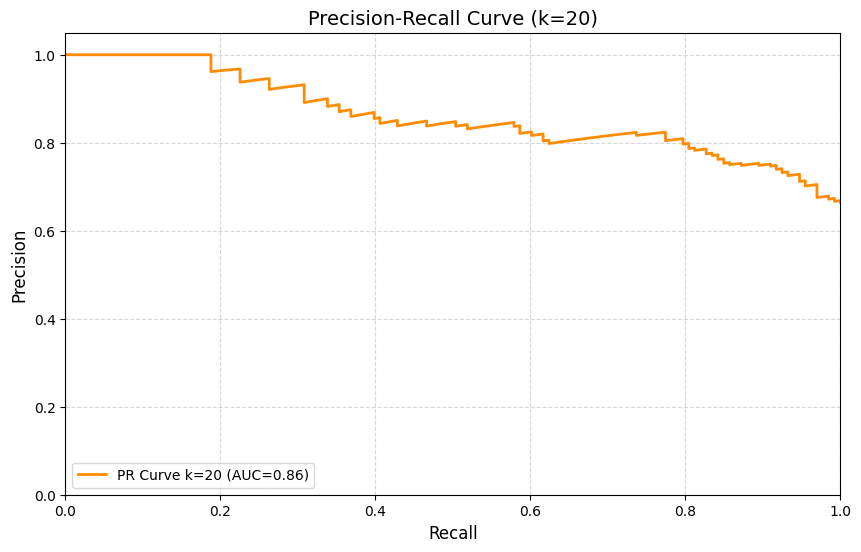

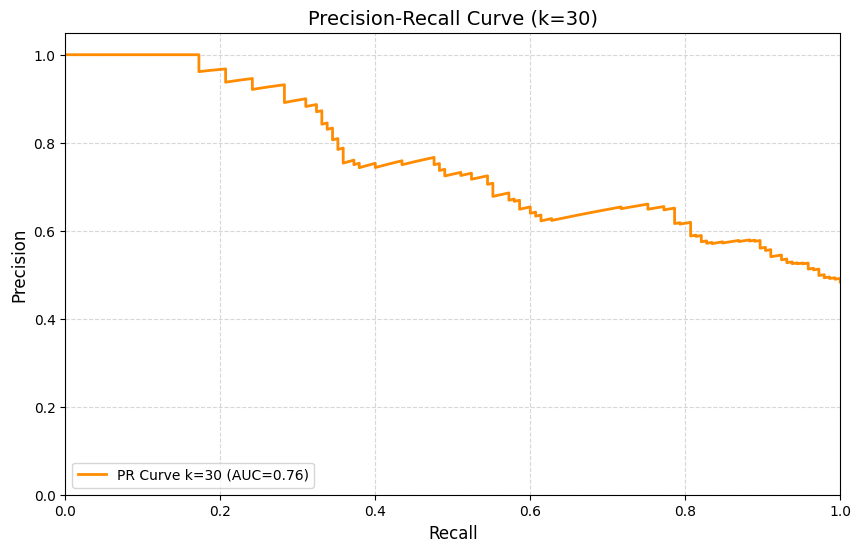

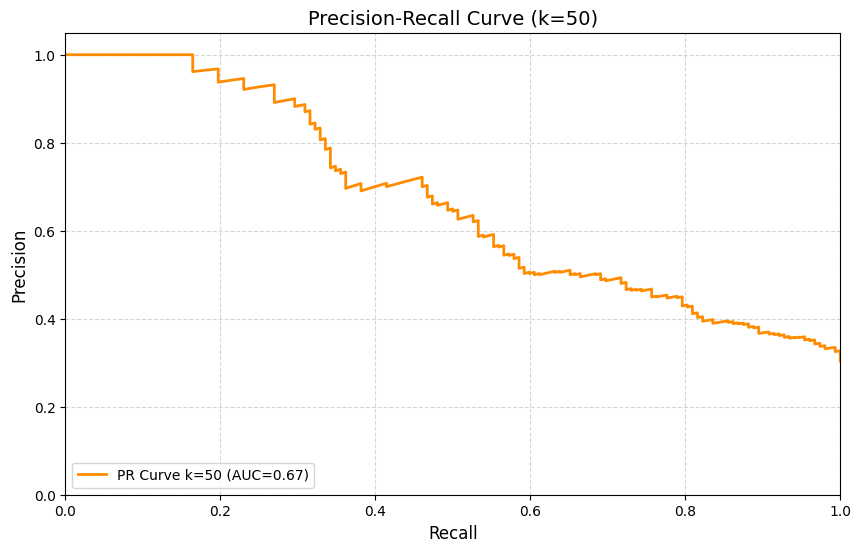

In [29]:
qrels_dict = {}
qrels_df = pd.read_csv(qrels_file, sep=r'\s+', header=None, 
                       names=['QueryID', 'Iteration', 'DocID', 'Relevance'], 
                       dtype={'QueryID': str, 'DocID': str})
for _, row in qrels_df.iterrows():
    if row['Relevance'] > 0:
        if row['QueryID'] not in qrels_dict: qrels_dict[row['QueryID']] = set()
        qrels_dict[row['QueryID']].add(row['DocID'])

for k in k_scenarios:
    y_true = []
    y_scores = []
    
    results_file_path = f"../results/phase1_results_k{k}.txt"
    
    if os.path.exists(results_file_path):
        with open(results_file_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                qid = parts[0]; doc_id = parts[2]; score = float(parts[4])
                
                is_relevant = 1 if (qid in qrels_dict and doc_id in qrels_dict[qid]) else 0
                y_true.append(is_relevant)
                y_scores.append(score)
        
        try:
            precision, recall, _ = precision_recall_curve(y_true, y_scores)
            pr_auc = auc(recall, precision)
            
            plt.figure(figsize=(10, 6))
            plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR Curve k={k} (AUC={pr_auc:.2f})')
            plt.title(f'Precision-Recall Curve (k={k})', fontsize=14)
            plt.xlabel('Recall', fontsize=12)
            plt.ylabel('Precision', fontsize=12)
            plt.legend(loc="lower left")
            plt.grid(True, linestyle='--', alpha=0.5)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.show()
            
        except Exception as e:
            print(f"Error creating PR Curve for k={k}: {e}")
    else:
        print(f"Results file for k={k} not found.")

### Ανάλυση Κορεσμού Συχνότητας

Το παρακάτω διάγραμμα απεικονίζει τη σχέση μεταξύ της συχνότητας εμφάνισης ενός όρου ($tf_{t,d}$) και του βάρους που αποδίδει σε αυτόν ο αλγόριθμος BM25 ($w_{t,d}$).

Στον άξονα Χ βλέπουμε πόσες φορές εμφανίζεται η λέξη στο κείμενο και στον άξονα Υ πόσο "σκορ" κερδίζει το έγγραφο από αυτή τη λέξη.

**Παρατηρήσεις:**
* **Φθίνουσα Απόδοση (Diminishing Returns):** Παρατηρούμε ότι η καμπύλη του BM25 (κόκκινη γραμμή) αυξάνεται γρήγορα για τις πρώτες εμφανίσεις της λέξης (tf 1 έως 3), αλλά στη συνέχεια "κορεζεται" (γίνεται οριζόντια).
* **Η σημασία του $k_1=2.0$:** Η επιλογή της παραμέτρου $k_1=2.0$ (έναντι της προεπιλογής 1.2) επιτρέπει στην καμπύλη να ανέβει ψηλότερα και να κορεστεί πιο αργά. Αυτό σημαίνει ότι το σύστημά μας συνεχίζει να επιβραβεύει την επανάληψη μιας λέξης-κλειδί περισσότερο από ό,τι το προεπιλεγμένο μοντέλο, δίνοντας έμφαση στα πολύ πλούσια σε πληροφορία έγγραφα.
* **Σύγκριση με Log-TF:** Σε αντίθεση με το παραδοσιακό λογαριθμικό TF (μπλε γραμμή) που αυξάνεται επ' άπειρον, το BM25 έχει ένα άνω όριο (ασύμπτωτη στο $k_1 + 1$), αποτρέποντας τη στρέβλωση των αποτελεσμάτων από spam επαναλήψεις λέξεων.

### Ανάλυση Κορεσμού Συχνότητας (TF Saturation)

Το παραπάνω διάγραμμα αναδεικνύει τη θεμελιώδη διαφορά του αλγορίθμου BM25 έναντι της παραδοσιακής λογαριθμικής συχνότητας (Log-TF), καθώς και την επίδραση της παραμέτρου $k_1$.

1.  **Έλεγχος Κορεσμού (Saturation Control):** Σε αντίθεση με την μπλε διακεκομμένη γραμμή (Standard Log-TF) που αυξάνεται επ' άπειρον, οι καμπύλες του BM25 συγκλίνουν σε ένα ανώτατο όριο (ασύμπτωτη). Αυτό προστατεύει το σύστημα από το να υπερ-βαθμολογεί έγγραφα που επαναλαμβάνουν καταχρηστικά την ίδια λέξη ("keyword stuffing").

2.  **Η Επιλογή $k_1 = 2.0$ (Κόκκινη Γραμμή):**
    * Συγκρίνοντας την κόκκινη γραμμή (η παραμετροποίησή μας) με την γκρι (Default $k_1=1.2$), παρατηρούμε ότι η δική μας καμπύλη κορέζεται **πιο αργά**.
    * Το ανώτατο όριο σκορ για έναν όρο αυξάνεται από $2.2$ (στο default) σε $3.0$ (στο δικό μας).
    * **Πρακτική Σημασία:** Αυτό σημαίνει ότι το σύστημά μας συνεχίζει να "επιβραβεύει" την εμφάνιση μιας λέξης-κλειδί ακόμα και αν έχει ήδη εμφανιστεί 5-10 φορές. Αυτή η συμπεριφορά είναι επιθυμητή σε επιστημονικά κείμενα, όπου η συχνή επανάληψη ενός όρου συνήθως υποδηλώνει ότι το έγγραφο εστιάζει βαθιά στο συγκεκριμένο θέμα, και δεν είναι απλώς μια επιφανειακή αναφορά.

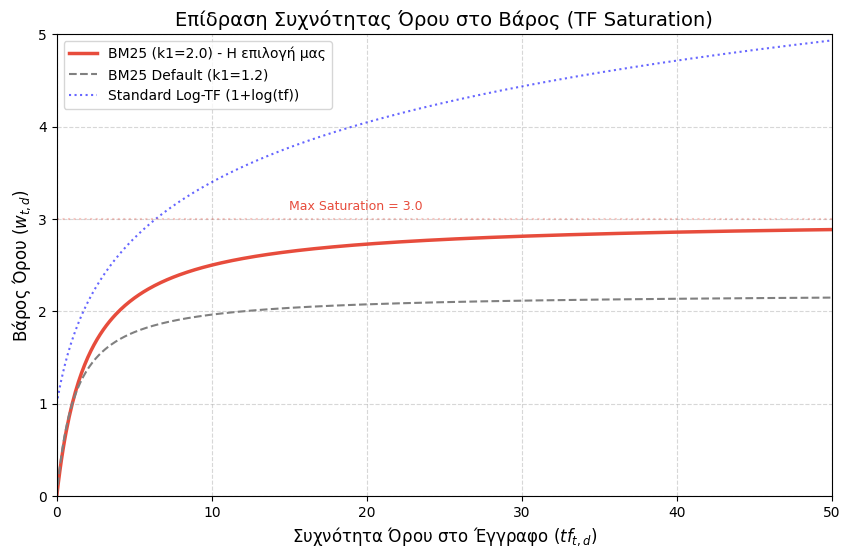

In [30]:
tf = np.linspace(0, 50, 500)

k1_current = 2.0  
k1_default = 1.2 

bm25_weight_custom = (tf * (k1_current + 1)) / (tf + k1_current)
bm25_weight_default = (tf * (k1_default + 1)) / (tf + k1_default)

linear_tf = tf 
log_tf = np.log(1 + tf) 

plt.figure(figsize=(10, 6))
plt.plot(tf, bm25_weight_custom, label=f'BM25 (k1={k1_current}) - Η επιλογή μας', color='#e74c3c', linewidth=2.5)
plt.plot(tf, bm25_weight_default, label=f'BM25 Default (k1={k1_default})', color='gray', linestyle='--')
plt.plot(tf, 1 + np.log(tf + 1), label='Standard Log-TF (1+log(tf))', color='blue', linestyle=':', alpha=0.6)

plt.title("Επίδραση Συχνότητας Όρου στο Βάρος (TF Saturation)", fontsize=14)
plt.xlabel("Συχνότητα Όρου στο Έγγραφο ($tf_{t,d}$)", fontsize=12)
plt.ylabel("Βάρος Όρου ($w_{t,d}$)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlim(0, 50)
plt.ylim(0, 5.0)

plt.axhline(y=k1_current+1, color='#e74c3c', linestyle=':', alpha=0.3)
plt.text(15, k1_current+1.1, f'Max Saturation = {k1_current+1}', color='#e74c3c', fontsize=9)

plt.show()